# Prediction Model Generation

Data Explanation:

| File | Content | Comment |
| --- | --- | --- |
| ISCORING_ADMISSION | Admission of a patient | .843 |
| ISCORING_GROUPS | Aggregated SAPS & TISS score per day and patient | .843 |
| ISCORING_ITEMS | Each score entry for each patient and each day | .843 |
| ISCORING_TYPES | Overall Score Types (SAPS, TISS, SOFA, COMPLEXA1, COMPLEXA2, COMPLEXP) | SCT_KEY=1, 2 equals SAPS & TISS Score |
| ISCORING_VALUETYPES | Detailed SAPS, TISS & SOFA SCORE | 1-14: SAPS, 15-24: TISS, 26-30: SOFA |

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xlrd
import os
import json
import xgboost
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from matplotlib import pyplot
from xgboost import plot_importance
import ipywidgets as widgets
from IPython.display import display, clear_output
import io

In [11]:
loaded_model = XGBClassifier()
loaded_model.load_model("los_prediction.json")

In [12]:
SCORING_TYPES = pd.DataFrame([{'SCT_KEY': 4,
  'SCT_CODE': 'COMPLEXA2',
  'SCT_DESCRIPTION': 'Aufwändige Intensivmedizinische Komplexbehandlung Erwachsene',
  'SCT_HAS_ITEMS': 0},
 {'SCT_KEY': 1,
  'SCT_CODE': 'SAPS',
  'SCT_DESCRIPTION': 'Simplified Acute Physiology Score',
  'SCT_HAS_ITEMS': 1},
 {'SCT_KEY': 2,
  'SCT_CODE': 'TISS',
  'SCT_DESCRIPTION': 'Therapeutic Intervention Scoring System 10',
  'SCT_HAS_ITEMS': 1},
 {'SCT_KEY': 6,
  'SCT_CODE': 'SOFA',
  'SCT_DESCRIPTION': 'Sepsis-related Organ Failure Assessment',
  'SCT_HAS_ITEMS': 1},
 {'SCT_KEY': 3,
  'SCT_CODE': 'COMPLEXA1',
  'SCT_DESCRIPTION': 'Intensivmedizinische Komplexbehandlung Erwachsene',
  'SCT_HAS_ITEMS': 0},
 {'SCT_KEY': 5,
  'SCT_CODE': 'COMPEXP1',
  'SCT_DESCRIPTION': 'Intensivmedizinische Komplexbehandlung Kinder',
  'SCT_HAS_ITEMS': 1}])

VALUE_TYPES = pd.DataFrame([{'SCVT_KEY': 1,
  'SCVT_CODE': 'HEARTRATE',
  'SCVT_DESCRIPTION': 'SAPS Herzfrequenz',
  'SCVT_SCT_KEY': 1},
 {'SCVT_KEY': 2,
  'SCVT_CODE': 'BLOODPRESSURE',
  'SCVT_DESCRIPTION': 'SAPS systolischer Blutdruck',
  'SCVT_SCT_KEY': 1},
 {'SCVT_KEY': 3,
  'SCVT_CODE': 'TEMPERATURE',
  'SCVT_DESCRIPTION': 'SAPS Temperatur',
  'SCVT_SCT_KEY': 1},
 {'SCVT_KEY': 4,
  'SCVT_CODE': 'OXYGENRATIO',
  'SCVT_DESCRIPTION': 'SAPS Horovitzindex',
  'SCVT_SCT_KEY': 1},
 {'SCVT_KEY': 5,
  'SCVT_CODE': 'URINE',
  'SCVT_DESCRIPTION': 'SAPS Urinausfuhr',
  'SCVT_SCT_KEY': 1},
 {'SCVT_KEY': 6,
  'SCVT_CODE': 'UREA',
  'SCVT_DESCRIPTION': 'SAPS Harnstoff',
  'SCVT_SCT_KEY': 1},
 {'SCVT_KEY': 7,
  'SCVT_CODE': 'LEUCOCYTES',
  'SCVT_DESCRIPTION': 'SAPS Leukozyten',
  'SCVT_SCT_KEY': 1},
 {'SCVT_KEY': 8,
  'SCVT_CODE': 'POTASSIUM',
  'SCVT_DESCRIPTION': 'SAPS Kalium',
  'SCVT_SCT_KEY': 1},
 {'SCVT_KEY': 9,
  'SCVT_CODE': 'SODIUM',
  'SCVT_DESCRIPTION': 'SAPS Natrium',
  'SCVT_SCT_KEY': 1},
 {'SCVT_KEY': 10,
  'SCVT_CODE': 'BICARBONATE',
  'SCVT_DESCRIPTION': 'SAPS Bicarbonat',
  'SCVT_SCT_KEY': 1},
 {'SCVT_KEY': 11,
  'SCVT_CODE': 'BILIRUBIN',
  'SCVT_DESCRIPTION': 'SAPS Bilirubin',
  'SCVT_SCT_KEY': 1},
 {'SCVT_KEY': 12,
  'SCVT_CODE': 'ADMISSIONSTATE',
  'SCVT_DESCRIPTION': 'SAPS Aufnahmestatus',
  'SCVT_SCT_KEY': 1},
 {'SCVT_KEY': 13,
  'SCVT_CODE': 'CHRONICALDISEASE',
  'SCVT_DESCRIPTION': 'SAPS chronisches Leiden',
  'SCVT_SCT_KEY': 1},
 {'SCVT_KEY': 14,
  'SCVT_CODE': 'AGE',
  'SCVT_DESCRIPTION': 'SAPS Alter bei Scoreerhebung',
  'SCVT_SCT_KEY': 1},
 {'SCVT_KEY': 25,
  'SCVT_CODE': 'LUNG',
  'SCVT_DESCRIPTION': 'SOFA Atmung',
  'SCVT_SCT_KEY': 6},
 {'SCVT_KEY': 15,
  'SCVT_CODE': 'VENTILATION',
  'SCVT_DESCRIPTION': 'TISS 10 Apparative Beatmung',
  'SCVT_SCT_KEY': 2},
 {'SCVT_KEY': 16,
  'SCVT_CODE': 'CATECHOLAMINES',
  'SCVT_DESCRIPTION': 'TISS 10 Infusion multipler Katecholamine',
  'SCVT_SCT_KEY': 2},
 {'SCVT_KEY': 17,
  'SCVT_CODE': 'SUBSTITUTION',
  'SCVT_DESCRIPTION': 'TISS 10 Flüssigkeitsersatz in hohen Mengen\r\r\r\n(>5l/24h)',
  'SCVT_SCT_KEY': 2},
 {'SCVT_KEY': 18,
  'SCVT_CODE': 'ARTERIAL',
  'SCVT_DESCRIPTION': 'TISS 10 Peripherer arterieller Katheter',
  'SCVT_SCT_KEY': 2},
 {'SCVT_KEY': 19,
  'SCVT_CODE': 'CARDIAC',
  'SCVT_DESCRIPTION': 'TISS 10 Linksvorhofkatheter/Pulmonaliskatheter',
  'SCVT_SCT_KEY': 2},
 {'SCVT_KEY': 20,
  'SCVT_CODE': 'RENAL',
  'SCVT_DESCRIPTION': 'TISS 10 Hämofiltration/Dialyse',
  'SCVT_SCT_KEY': 2},
 {'SCVT_KEY': 21,
  'SCVT_CODE': 'CRANIAL',
  'SCVT_DESCRIPTION': 'TISS 10 Intrakranielle Druckmessung',
  'SCVT_SCT_KEY': 2},
 {'SCVT_KEY': 22,
  'SCVT_CODE': 'METABOLIC',
  'SCVT_DESCRIPTION': 'TISS 10 Behandlung einer metabolischen Azidose/Alkalose',
  'SCVT_SCT_KEY': 2},
 {'SCVT_KEY': 23,
  'SCVT_CODE': 'INTERVENTION',
  'SCVT_DESCRIPTION': 'TISS 10 Spezielle Interventionen auf der ITS',
  'SCVT_SCT_KEY': 2},
 {'SCVT_KEY': 24,
  'SCVT_CODE': 'ACTION',
  'SCVT_DESCRIPTION': 'TISS 10 Aktionen außerhalb der Station',
  'SCVT_SCT_KEY': 2},
 {'SCVT_KEY': 26,
  'SCVT_CODE': 'KIDNEY',
  'SCVT_DESCRIPTION': 'SOFA Niere',
  'SCVT_SCT_KEY': 6},
 {'SCVT_KEY': 27,
  'SCVT_CODE': 'LIVER',
  'SCVT_DESCRIPTION': 'SOFA Leber',
  'SCVT_SCT_KEY': 6},
 {'SCVT_KEY': 28,
  'SCVT_CODE': 'CARDIAC',
  'SCVT_DESCRIPTION': 'SOFA Herz-Kreislauf-System',
  'SCVT_SCT_KEY': 6},
 {'SCVT_KEY': 29,
  'SCVT_CODE': 'BLOOD',
  'SCVT_DESCRIPTION': 'SOFA Gerinnung',
  'SCVT_SCT_KEY': 6},
 {'SCVT_KEY': 30,
  'SCVT_CODE': 'CNS',
  'SCVT_DESCRIPTION': 'SOFA Nervensystem',
  'SCVT_SCT_KEY': 6}])

In [13]:
def data_processing(df):

    df_value_scoring_types = pd.merge(
        VALUE_TYPES[['SCVT_KEY', 'SCVT_CODE', 'SCVT_SCT_KEY']],
        SCORING_TYPES[['SCT_KEY', 'SCT_CODE']],
        left_on='SCVT_SCT_KEY', right_on='SCT_KEY'
    ).drop(['SCVT_SCT_KEY', 'SCT_KEY'], axis=1)


    df_value_scoring_types['INDICATOR'] = df_value_scoring_types['SCT_CODE'] + "_" + df_value_scoring_types['SCVT_CODE']
    df_indicators = df_value_scoring_types.drop(['SCVT_CODE', 'SCT_CODE'], axis=1)

    df_case_type_indicators = pd.merge(df, df_indicators, left_on='Key', right_on='SCVT_KEY')
    df_case_type_indicators = df_case_type_indicators.drop(['Item', 'SCVT_KEY'], axis=1)


    daily_input = df_case_type_indicators.pivot_table(
        index=['Fallnummer'],
        columns='INDICATOR', values='Points'
    ).reset_index().rename_axis("", axis="columns")

    return daily_input

In [15]:
def get_proba(patients):
    X_snapshot_allScores = patients.iloc[:,[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]]
    prediction_class_xgboost_loaded_model = loaded_model.predict_proba(X_snapshot_allScores)
    prediction_class_xgboost_loaded_model = pd.DataFrame(prediction_class_xgboost_loaded_model)

    FirstFive_xgboost_class_loaded_model = prediction_class_xgboost_loaded_model.iloc[:, 0:5]
    AfterFive_xgboost_class_loaded_model = prediction_class_xgboost_loaded_model.drop([0, 1, 2, 3, 4], axis=1).sum(axis=1)
    AfterFive_xgboost_class_loaded_model = pd.DataFrame(AfterFive_xgboost_class_loaded_model, columns=[">=5"])
    AllDays_xgboost_class_loaded_model = pd.concat([FirstFive_xgboost_class_loaded_model, AfterFive_xgboost_class_loaded_model], axis=1)
    
    return AllDays_xgboost_class_loaded_model

In [27]:
upload_widget = widgets.FileUpload(
    accept='.csv',
    multiple=False,
    description='CSV Datei auswählen',
)

predict_button = widgets.Button(
    description='Prediction durchführen',
    button_style='primary'
)

output = widgets.Output()

data_container = {}

def on_upload_change(change):
    with output:
        clear_output()
        if len(upload_widget.value) == 0:
            print("Keine Datei ausgewählt.")
            data_container['df'] = None
            return
        file_info = upload_widget.value[0]
        uploaded_filename = file_info['name']
        uploaded_bytes = file_info['content']
        try:
            df = pd.read_csv(io.BytesIO(uploaded_bytes), delimiter=';', encoding='utf-8')
            data_container['df'] = df
            print(f"Datei '{uploaded_filename}' erfolgreich geladen. Drücke jetzt auf 'Prediction durchführen'.")
        except Exception as e:
            print("Fehler beim Einlesen der Datei:", e)
            data_container['df'] = None

def on_predict_clicked(b):
    with output:
        clear_output()
        df = data_container.get('df', None)
        if df is None:
            print("Bitte zuerst eine gültige CSV-Datei auswählen und hochladen.")
            return
        try:
            print("Ausgangsdaten nach Preprocessing (`data_processing(df)`):")
            patients = data_processing(df)
            display(patients)
            print("\nPrediction Ergebnis (`get_proba(patients)`):")
            prediction = get_proba(patients)
            display(prediction)
        except Exception as e:
            print("Fehler bei der Prediction:", e)

upload_widget.observe(on_upload_change, names='value')
predict_button.on_click(on_predict_clicked)

display(upload_widget, predict_button, output)

FileUpload(value=(), accept='.csv', description='CSV Datei auswählen')

Button(button_style='primary', description='Prediction durchführen', style=ButtonStyle())

Output()

# Model Metrics:

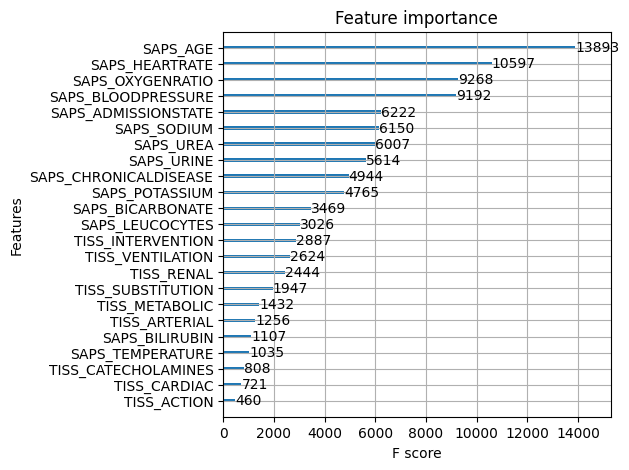

SAPS_ADMISSIONSTATE 0.035304666
SAPS_AGE 0.0370038
SAPS_BICARBONATE 0.04499989
SAPS_BILIRUBIN 0.03308382
SAPS_BLOODPRESSURE 0.04026779
SAPS_CHRONICALDISEASE 0.035204113
SAPS_HEARTRATE 0.03738288
SAPS_LEUCOCYTES 0.039335642
SAPS_OXYGENRATIO 0.0483448
SAPS_POTASSIUM 0.04023676
SAPS_SODIUM 0.040523574
SAPS_TEMPERATURE 0.039198875
SAPS_UREA 0.035960324
SAPS_URINE 0.04242069
TISS_ACTION 0.035270836
TISS_ARTERIAL 0.039289758
TISS_CARDIAC 0.0375432
TISS_CATECHOLAMINES 0.032121293
TISS_CRANIAL 0.0
TISS_INTERVENTION 0.037243877
TISS_METABOLIC 0.037054226
TISS_RENAL 0.04155978
TISS_SUBSTITUTION 0.049330037
TISS_VENTILATION 0.14131936


C:\Users\hwitteborg\AppData\Local\anaconda3\Lib\site-packages\xgboost\data.py:208: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


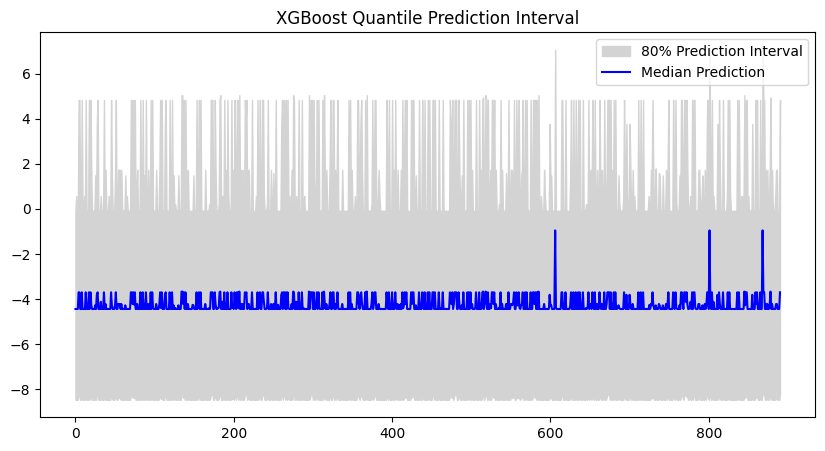

In [ ]:
xgboost.plot_importance(loaded_model)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()
for col,score in zip(X_train.columns,loaded_model.feature_importances_):
    print(col,score)
    
def quantile_loss(alpha):
    def loss(y_pred, dtrain):
        y_true = dtrain.get_label()
        error = y_true - y_pred
        grad = np.where(error < 0, -alpha, 1 - alpha)
        hess = np.ones_like(grad)  # Hessian ist konstant
        return grad, hess
    return loss


import xgboost as xgb

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test)

quantiles = [0.1, 0.5, 0.9]
quantile_models = {}
predictions = {}

for q in quantiles:
    params = {
        'max_depth': 3,
        'eta': 0.1,
        'objective': 'reg:squarederror',
        'verbosity': 0
    }
    model = xgb.train(params, dtrain, num_boost_round=100, obj=quantile_loss(q))
    quantile_models[q] = model
    predictions[q] = model.predict(dtest)
    
    
plt.figure(figsize=(10, 5))
plt.fill_between(range(len(X_test)), predictions[0.1], predictions[0.9], color='lightgrey', label='80% Prediction Interval')
plt.plot(predictions[0.5], label='Median Prediction', color='blue')
plt.title('XGBoost Quantile Prediction Interval')
plt.legend()
plt.show()